# Resonador A y B acoplado a una linea de transmision

Authors: Kelvin Ramos
Description: Resonador A fijado y variando la frecuencia del resonador B 


In [1]:
# Import useful packages
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
from collections import OrderedDict

# To create plots after geting solution data.
import matplotlib.pyplot as plt
import numpy as np

# Packages for the simple design
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.launchpad_wb_driven import LaunchpadWirebondDriven
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee


# Function to find the length of lines

In [2]:
from scipy.constants import c

In [3]:
### f is float in GHz
def leng(f):
    f2=f*1e9 ## to GHz
    eff=(11.9+1)/2
    le=c/(4*np.sqrt(eff)*f2)
    le=le*1e3 # to milimeters
    return print(r'resonator length l={:.6f} mm for frequency f0={} GHz'.format(le,f))
leng(5.00001)

resonator length l=5.902146 mm for frequency f0=5.00001 GHz


In [4]:
# freq=np.array([6e9,7e9,8e9]) 
# for i in range(len(freq)):
#     z=leng(freq[i])
#     print(freq[i]*1e-9,'GHz,', z*1e3, 'mm')

# Chip design

Our chip design has a size of 3mm x 10mm with 200um of substrate. The dimensions of the cpw are: width=20um and gap=11um.

In [4]:
# Set up chip dimensions 
design = designs.DesignPlanar()
design._chips['main']['size']['size_x'] = '6mm'
design._chips['main']['size']['size_y'] = '3mm'
design._chips['main']['size']['size_z'] = '-400um'
# design._chips['main']['size']['center_x'] = '0mm'
# design._chips['main']['size']['center_y'] = '0mm'

# Resonator and feedline gap width (W) and center conductor width (S) from reference 2
design.variables['cpw_width'] = '20um' #S from reference 2
design.variables['cpw_gap'] = '11um' #W from reference 2


design.overwrite_enabled = True

hfss = design.renderers.hfss

# Open GUI
gui = MetalGUI(design)

# Define the geometry

Here we will have a single feedline couple to 3 CPW resonators.

We need 2 lauchpads, 3 capacitors, 3 transmission lines and 3 short terminals

## Capacitors
The coupling length of our capacitors should be 115um, 102um and 85um for a resonance frequency of 6.6 GHz, 7.4 GHz and 8.45 GHz, respectively. 

In [5]:
### position

########  CAPACITORS

yy_pos='1.5mm'   #capacitors' location
xx_1, xx_2 = '1.0mm', '3.5mm'

##### same parameters

general=dict(prime_width='20um', prime_gap='11um', second_width='20um', 
             second_gap='11um', down_length='100um', fillet='90um', 
             hfss_wire_bonds=True, coupling_space='10um' )


In [6]:
couplings=np.array([154.5 ,154.5]) ## factor de calidad 30K
fill=90
ad_coupl=fill+couplings
ad_coupl


array([244.5, 244.5])

In [7]:
###======================================================================
##### In our first experience, we have the following parameters

### for coupling_length=125um -> 75um,for 112um -> 62um, for 95um-> 45um
###

### so we need to add the fillet length to our coupling length
###======================================================================
##### lc=115um+90um

ubia=dict(pos_x=xx_1, pos_y=yy_pos, coupling_length='244.5um',
         gds_cell_name='cap_a',**general)

##### lc=102um+50um
ubib=dict(pos_x=xx_2, pos_y=yy_pos, coupling_length='244.5um',
          gds_cell_name='cap_b', **general)

Capacitora = CoupledLineTee(design, 'Capacitora', options=ubia)
Capacitorb = CoupledLineTee(design, 'Capacitorb', options=ubib)

gui.rebuild()
gui.autoscale()

# Launchpads
The more consistent parameter for the launchpads are width=120um and gap=61um. So that we have 50 Ohm

In [8]:
########### Launchpads position

# Driven Lauchpad 1

x1 = '-0.2mm'  ## 0.0
y1 = yy_pos

# Driven Launchpad 2
x2 = '4.7mm'
y2 = yy_pos ## 2.8

general_2=dict(lead_length='10um', pad_width='120um', pad_gap='61um', 
               trace_width='20um', trace_gap='11um' )

In [9]:
###################
# Single feedline #
###################


ops_1 = Dict(chip='main', pos_x=x1, pos_y=y1, orientation='360',
             gds_cell_name='LP1', **general_2)

LP1 = LaunchpadWirebondDriven(design, 'LP1', options = ops_1)


ops_2 = Dict(chip='main', pos_x=x2, pos_y=y2, orientation='180',  
            gds_cell_name='LP2', **general_2)

LP2 = LaunchpadWirebondDriven(design, 'LP2', options = ops_2)


# Rebuild the GUI
gui.rebuild()
gui.autoscale()

In [10]:
Capacitora.pin_names

{'prime_end', 'prime_start', 'second_end'}

# Transmission lines
Here we connect the capacitors with the launchpads

In [11]:
general_3 =  dict(trace_width ='20um', trace_gap ='11um', fillet='99um',
                  hfss_wire_bonds = True )

In [12]:
# Using path finder to connect the two launchpads
# Using path finder to connect the two launchpads


#### LP1 capacitor A
ops_linea_a= Dict(chip='main', gds_cell_name='linea',
                lead=Dict(end_straight='0.0mm'),
                pin_inputs=Dict(start_pin=Dict(component='LP1',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='Capacitora',
                                                    pin='prime_start')
                                            ), **general_3)

linea_a = RoutePathfinder(design, 'linea_a', options = ops_linea_a)


### capacitor A - capacitor B

ops_linea_b = Dict(chip='main', gds_cell_name='lineaa',
                  lead=Dict(end_straight='0.0mm'),
                  pin_inputs=Dict(      start_pin=Dict(
                                                    component='Capacitora',
                                                    pin='prime_end'),
                                        end_pin=Dict(
                                                    component='Capacitorb',
                                                    pin='prime_start')
                                            ), **general_3)


linea_b = RoutePathfinder(design, 'linea_b', options = ops_linea_b)




#### LP2-capacitor B
ops_lineab=Dict(chip='main', gds_cell_name='lineac',
                                            lead=Dict(end_straight='0.0mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Capacitorb',
                                                    pin='prime_end'),
                                                end_pin=Dict(
                                                    component='LP2',
                                                    pin='tie')
                                            ), **general_3)

lineab = RoutePathfinder(design, 'lineab', options = ops_lineab)



# Rebuild the GUI
gui.rebuild()
gui.autoscale()

# Resonators
The resonators are lambda/4 and each of them has a length of 4.5mm, 4.0mm  and 3.5mm.  

In [13]:
general_4= dict(trace_width ='20um', trace_gap ='11um', hfss_wire_bonds = True, fillet='90 um')

In [17]:
frequ=np.array([5.0, 5.0004])
for i in frequ:
    leng(i)

resonator length l=5.902158 mm for frequency f0=5.0 GHz
resonator length l=5.901686 mm for frequency f0=5.0004 GHz


In [16]:
ad_coupl

array([244.5, 244.5])

In [18]:
len_true=[5.9022,5.901686]

In [19]:
len_true-ad_coupl*1e-3

array([5.6577  , 5.657186])

In [20]:
######################
# lambda/4 resonator #
######################

# First we define the two end-points
#otg1 = OpenToGround(design, 'otg1', options=Dict(chip='main', pos_x='2.0 mm',  pos_y='2.748', orientation='-180',
                                                 #width='20um', gap='11um', termination_gap='11 um'))
yy_fin='0.15mm'

otg2_a = ShortToGround(design, 'otg2_a', options=Dict(chip='main', pos_x='1.0 mm',  pos_y=yy_fin, orientation='0'))
##============================================
#otg1a = OpenToGround(design, 'otg1a', options=Dict(chip='main', pos_x='4.5mm',  pos_y='2.748mm', orientation='180',
                                                   #width='20um', gap='11um', termination_gap='11 um'))
otg2_b = ShortToGround(design, 'otg2_b', options=Dict(chip='main', pos_x='3.5mm',  pos_y=yy_fin, orientation='0'))
##=============================================
# = OpenToGround(design, 'otg1b', options=Dict(chip='main', pos_x='7.0mm',  pos_y='2.748mm', orientation='180', 
                                                   #width='20um', gap='11um', termination_gap='11 um'))


# Use RouteMeander to fix the total length of the resonator
####===================================================================================

ops_meandro_A= Dict(chip='main', total_length='5.6577mm', gds_cell_name='meandro',
                  lead = Dict(start_straight='400um', end_straight='100um'), 
                  meander=Dict(spacing='250um', asymmetry='0um'),
                  pin_inputs=Dict(
                              start_pin=Dict(component='Capacitora', pin='second_end'),
                              end_pin=Dict(component='otg2_a', pin='short')), **general_4)

meandro_A = RouteMeander(design, 'meandro_A',  options=ops_meandro_A)

#####===================================================================================

ops_meandro_B=Dict(chip='main', total_length='5.657186mm', gds_cell_name='meandroa', 
        lead = Dict(start_straight='400um', end_straight='100um'),
        meander=Dict(spacing='250um', asymmetry='0um'),
        pin_inputs=Dict(
            start_pin=Dict(component='Capacitorb', pin='second_end'),
            end_pin=Dict(component='otg2_b', pin='short')), **general_4)

meandro_B = RouteMeander(design, 'meandro_B',  options=ops_meandro_B)



# rebuild the GUI
gui.rebuild()
gui.autoscale()

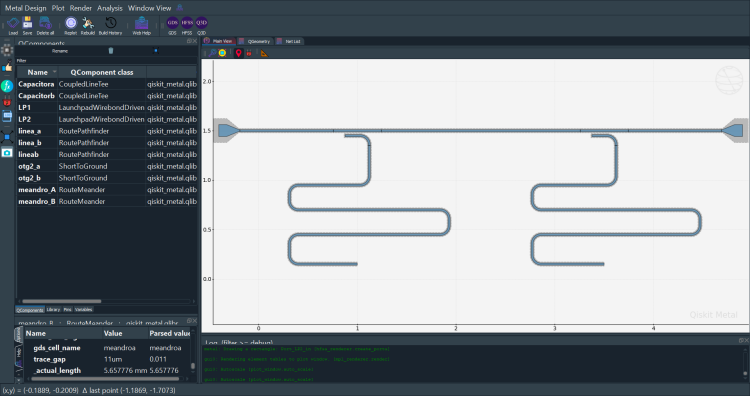

In [304]:
gui.autoscale()
gui.screenshot()


# Export Gds

In [73]:
a_gds = design.renderers.gds
### import and place the cell names in the Fake_Junctions
a_gds.options['path_filename'] = 'Fake_Junctions.GDS'

In [74]:
## for fillet the short segments, True means no fillet
a_gds.options['short_segments_to_not_fillet'] = 'False'

scale_fillet = 2.0
a_gds.options['check_short_segments_by_scaling_fillet'] = scale_fillet

In [75]:
# Restore a_gds options

a_gds.options.no_cheese['view_in_file']['main']={1: False}
a_gds.options.cheese['view_in_file']['main']={1: False}
a_gds.options['max_points'] = '8191'
a_gds.options['no_cheese']['buffer']='50um'
# We will shift the center of the chip to origin

design.chips.main.size['center_x'] = '5.0mm'
design.chips.main.size['center_y'] = '1.5mm'
design.rebuild()

### For demo, set max_points to 8191 and look at the GDS output.
a_gds.options['max_points'] = '8191'

# We next export it to GDS

design.renderers.gds.export_to_gds("7c7d4c8d5Gcq100K.gds")

1

In [33]:
#Many ways to view the QGeometry tables.
#If you want to view, uncomment below lines and and run it.

#design.qgeometry.tables
#design.qgeometry.tables['path']
#design.qgeometry.tables['poly']

# EPR

In [344]:
from qiskit_metal.analyses.quantization import EPRanalysis
eig_res = EPRanalysis(design, "hfss")

In [345]:
hfss = eig_res.sim.renderer

In [346]:
hfss.start() ## start hfss

INFO 02:32PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:32PM [load_ansys_project]: 	Opened Ansys App
INFO 02:32PM [load_ansys_project]: 	Opened Ansys Desktop v2018.0.0
INFO 02:32PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Quantum Circuits IB/Documents/Kelvin/qiskit-metal/qmetal/simu/resonator/code_qm/5GHz/data/
	Project:   Triple
INFO 02:32PM [connect_design]: 	Opened active design
	Design:    Rs_AB [Solution type: Eigenmode]
INFO 02:32PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:32PM [connect]: 	Connected to project "Triple" and design "Rs_AB" 😀 



True

In [347]:
# clean the design if needed
hfss.clean_active_design()

In [348]:
hfss.activate_ansys_design("Rs_AB", 'eigenmode')  # use new_ansys_design() to force creation of a blank design

INFO 02:32PM [connect_design]: 	Opened active design
	Design:    Rs_AB [Solution type: Eigenmode]


In [349]:
hfss.render_design([], [])
#hfss.save_screenshot()

In [350]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 10
#setup.delta_f=0.01
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

# Next 2 lines are counterinuitive, since there is no junction in this resonator.
# However, these are necessary to make pyEPR work correctly. Please do note delete
hfss.pinfo.design.set_variable('Lj', '10 nH')
hfss.pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()


Number of eigenmodes to find             = 1
Number of simulation passes              = 10
Convergence freq max delta percent diff  = 0.1



INFO 02:33PM [analyze]: Analyzing setup Setup


In [351]:
eig_res.sim.convergence_t, eig_res.sim.convergence_f, _ = hfss.get_convergences()
eig_res.sim.plot_convergences()

02:38PM 51s INFO [get_f_convergence]: Saved convergences to C:\Users\Quantum Circuits IB\Documents\Kelvin\qiskit-metal\qmetal\simu\resonator\code_qm\Doble\hfss_eig_f_convergence.csv


# Scattering Analysis

In [21]:
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim
em1 = ScatteringImpedanceSim(design, "hfss")

In [22]:
design_name= "Sweep_DrivenModal"
qcomp_render = [] # Means to render everything in qgeometry table.
open_terminations = []

# Here, pin LP1_in and LP2_in are converted into lumped ports,
#           each with an impedance of 50 Ohms. <br>
port_list = [('LP1', 'in', 50),
             ('LP2', 'in', 50)]
box_plus_buffer = True

In [23]:
# we use HFSS as rendere
hfss = em1.renderer
hfss.start()

INFO 03:47PM [connect_project]: Connecting to Ansys Desktop API...
INFO 03:47PM [load_ansys_project]: 	Opened Ansys App
INFO 03:47PM [load_ansys_project]: 	Opened Ansys Desktop v2018.0.0
INFO 03:47PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/Quantum Circuits IB/Documents/Kelvin/qiskit-metal/qmetal/simu/resonator/code_qm/Doble/
	Project:   Project32px
INFO 03:47PM [connect_design]: 	Opened active design
	Design:    32pix_v1 [Solution type: DrivenModal]
INFO 03:47PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 03:47PM [connect]: 	Connected to project "Project32px" and design "32pix_v1" 😀 



True

In [24]:
# Here we activate the design for a drivenmodal solution
hfss.activate_ansys_design("Res_AB", 'drivenmodal')
setup_args = Dict(max_delta_s=0.02)
setup_args.name = 'Setup'
hfss.edit_drivenmodal_setup(setup_args)

03:47PM 33s WARNING [activate_ansys_design]: The design_name=Res_AB was not in active project.  Designs in active project are: 
['HFSSDesign1', '32pix_v1'].  A new design will be added to the project.  
INFO 03:47PM [connect_design]: 	Opened active design
	Design:    Res_AB [Solution type: DrivenModal]
WARNING 03:47PM [connect_setup]: 	No design setup detected.
WARNING 03:47PM [connect_setup]: 	Creating driven modal default setup.
INFO 03:47PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
03:47PM 34s WARNING [edit_drivenmodal_setup]: In setup_args, key=max_delta_s, value=0.02 is not in pinfo.setup, the key/value pair from setup_args not added to Setup in Ansys.


In [25]:
# set buffer
hfss.options['x_buffer_width_mm'] = 0.4
hfss.options['y_buffer_width_mm'] = 0.4

In [26]:
# clean the design if needed
hfss.clean_active_design()

In [27]:
# render the design
hfss.render_design(selection=[], 
                   open_pins=open_terminations, 
                   port_list=port_list, 
                   box_plus_buffer = box_plus_buffer)


In [28]:
# for acurate simulations, make sure the mesh is fine enough for the meander
hfss.modeler.mesh_length(
                'cpw_mesh',
                ['trace_meandro_A', 'trace_meandro_B',
                 'second_cpw_Capacitora','second_cpw_Capacitorb'],
                MaxLength='0.01mm')

In [212]:
# hfss.modeler.mesh_length(
#                 'cpw_plane',
#                 ['trace_meandro','trace_meandroa','trace_meandrob'],
#                 MaxLength='10um')

# Broad sweet to find the resonance

In [30]:
hfss.add_sweep(setup_name="Setup", 
               name="Sweep", 
               start_ghz=1.0,
               stop_ghz=20.0,
               count=2001,
               type="Fast")

INFO 10:30AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)


In [29]:
hfss.analyze_sweep('Sweep', 'Setup')

INFO 10:08PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 10:08PM [analyze]: Analyzing setup Setup : Sweep


In [ ]:
hfss.plot_params(['S11', 'S21'])

In [ ]:
# extract the S21 parameters
freqs, Pcurves, Pparams = hfss.get_params(['S21'])

In [ ]:
# find armin 
f_res = freqs[np.argmin(np.abs(Pparams.S21.values))]
f_res

# Narrow sweep around the resonance found above

In [ ]:
#fine sweep
hfss.add_sweep(setup_name="Setup", 
               name="Sweep_narrow", 
               start_ghz=np.round(f_res/1e9,3)-0.01,
               stop_ghz=np.round(f_res/1e9,3)+0.01,
               count=1001,
               type="Fast") #slow but precise

In [ ]:
hfss.analyze_sweep('Sweep_narrow', 'Setup')

In [ ]:
hfss.plot_params(['S11', 'S21'])

# Close connections

In [47]:
em1.close()

Warning! 3 COM references still alive
Ansys will likely refuse to shut down


In [58]:
hfss.disconnect_ansys()

Warning! 3 COM references still alive
Ansys will likely refuse to shut down


In [50]:
gui.main_window.close()

True

In [ ]:
close()

In [46]:
import qiskit_metal
qiskit_metal.__version__

'0.0.4'